<a href="https://colab.research.google.com/github/Young1906/eeg00/blob/master/EEG_20191208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. SUBJECTS
![](https://scontent.fsgn5-6.fna.fbcdn.net/v/t1.15752-9/75561453_2563960453697238_5400349671623229440_n.png?_nc_cat=109&_nc_oc=AQlrHKGdSXoQyhYICFYLXwR6rzgBdn_zlzb4jDNcn5yzmiU6upWCc1Fze08Tr1HB4dU&_nc_ht=scontent.fsgn5-6.fna&oh=031ee40ea7636c68fabae23e0205defb&oe=5E899DF4)

# 1. Function and library

In [47]:
# Mounting drive:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
# Library
!pip install mne
from mne.io import read_raw_edf
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import welch, butter, lfilter
from scipy import signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import time
from scipy.interpolate import griddata
from tqdm import tqdm_notebook as tqdm
from numpy import ma
from urllib.request import urlopen

In [0]:
# Setting
FS = 500                                        #Sampling frequency
LOWCUT = 0.5                                    #Highpass
HIGHCUT = 45                                    #Lowpass
plt.rcParams['figure.figsize'] = [25, 5]

_WINDOW = 15

# Subjects
_DIR_PATH = './gdrive/My Drive/Project_Database'
_SESSION1 = [1528, 1520, 1530, 1507, 1523, 1492, 1517, 1515, 1489, 1503] #1489*
_SESSION2 = [1539, 1541, 1545, 1549, 1551, 1553, 1567, 1569, 1572, 1575]

_STG_PATH = "{_path}/{session}/{session}_alice/csv/STAGE.csv"
_EDF_PATH = "{_path}/{session}/{session}_alice/edf/A000{session}.edf"

In [0]:
# Fucntion to process data

def group_consecutives(vals, step=1):
    # https://stackoverflow.com/questions/7352684/
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

# Calculate Representative Rest1 mean:
def baseline_calc(a):
    e = np.mean(a)
    return a - e

# Banpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut=.5, highcut=45., fs=500, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def psd(s, _fs = FS, _avg='median', fmax = 60):
    """
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html
    
    scaling : { ‘density’, ‘spectrum’ }, optional

        Selects between computing the power spectral density (‘density’) where 
        Pxx has units of V**2/Hz if x is measured in V and computing the power
        spectrum (‘spectrum’) where Pxx has units of V**2 if x is measured in V.
        Defaults to ‘density’.

    """
    _nperseg = 4*_fs
    x, y = welch(s, fs=_fs, average=_avg, nperseg=_nperseg)
    x, y = x[np.where(x<fmax)], y.T[np.where(x<fmax)]

    return x, y 

def GET_PATH(session):
    """
    Return EDF file and STAGE.csv path
    """
    return _EDF_PATH.format_map({"_path":_DIR_PATH, "session":session}),\
    _STG_PATH.format_map({"_path":_DIR_PATH, "session":session})

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [0]:
class EEG():
    def __init__(self,path):
        self.raw = None
        self.baseline = None
        self.bandpass = None
        self.corrected = None
         
        # Raw data & meta data
        self.path_edf, self.path_stage = path
        raw = read_raw_edf(self.path_edf, preload=True, verbose=0)

        raw.pick_channels(['EEG Fp1-A2','EEG F7-A2','EEG F3-A2','EEG T5-A2', \
                           'EEG O1-A2','EEG Fp2-A1','EEG F4-A1','EEG F8-A1','EEG T6-A1','EEG O2-A1'])
        
        # Rename channel name to standard1005 
        raw.rename_channels({'EEG Fp1-A2': 'Fp1','EEG F7-A2': 'F7',
        'EEG F3-A2': 'F3', 'EEG T5-A2': 'T5','EEG O1-A2': 'O1',
        'EEG Fp2-A1': 'Fp2', 'EEG F4-A1': 'F4', 'EEG F8-A1': 'F8',
        'EEG T6-A1': 'T6', 'EEG O2-A1': 'O2'})
        raw.set_montage('standard_1005', raise_if_subset=False)

        self.raw = raw.copy()

        self.meas_date, _ = self.raw.info['meas_date']
        self.ch_names = self.raw.info['ch_names']
        
        # Stage file: 
        with open(self.path_stage, 'r') as f: 
            stages = f.read().splitlines()
        
            fname, lname, subject, start_date, start_time, \
             end_date, end_time = stages[0].split(',')
        
            stages = stages[1:]

        # Stages and stages indices
        self.stages = stages
        self.subject = subject
        
        task_indices = [idx for idx, _ in enumerate(self.stages) if _ == '13']
        self.tasks = group_consecutives(task_indices)

        rest_indices = [idx for idx, _ in enumerate(self.stages) if _ == '12']
        self.rests = group_consecutives(rest_indices)


        self.start_timestamp = time.mktime(
            datetime.strptime(f"{start_date} {start_time}", \
                              "%m/%d/%Y %I:%M:%S %p").timetuple())
        
        self.DIFFTIME = self.start_timestamp - self.meas_date



    def compute_avg_pxx(self):
        rest_pxx_avg = []
        task_pxx_avg = []
        
        loop = tqdm(self.ch_names, leave=False)

        for ch in loop:
            loop.set_description(ch)
            # Compute pxx for channel ch across chunk of 10s
            pxxs = []
            for task in tqdm(self.tasks, leave=False, desc='Task'):
                for chunk in tqdm(chunks(task, 10), leave=False, desc='Chunk'):
                    _start, _end = self.DIFFTIME + min(chunk), self.DIFFTIME + max(chunk)
                    # Croping task/rest chunk of _WINDOWS second
                    dat = self.raw.copy().crop(_start, _end)
                    # Apply preprocessing step: baseline + bandpass
                    dat.apply_function(baseline_calc)
                    dat.apply_function(butter_bandpass_filter)
                    # Welch PSD
                    sig = dat.copy().pick(ch).get_data()[0:,]
                    f, pxx = psd(sig)
                    pxxs.append(pxx)
            
            pxxs = np.array(pxxs)[:,:,0]
            pxx_avg = np.mean(pxxs, axis=0)
            task_pxx_avg.append(pxx_avg)

            # Compute pxx for channel ch across chunk of 10s
            pxxs = []
            for rest in tqdm(self.rests, leave=False, desc='Rest'):
                for chunk in tqdm(chunks(rest, 10), leave=False, desc='Chunk'):
                    _start, _end = self.DIFFTIME + min(chunk), self.DIFFTIME + max(chunk)
                    # Croping task/rest chunk of _WINDOWS second
                    dat = self.raw.copy().crop(_start, _end)
                    # Apply preprocessing step: baseline + bandpass
                    dat.apply_function(baseline_calc)
                    dat.apply_function(butter_bandpass_filter)
                    # Welch PSD
                    sig = dat.copy().pick(ch).get_data()[0:,]
                    
                    f, pxx = psd(sig)
                    pxxs.append(pxx)
            
            pxxs = np.array(pxxs)[:,:,0]
            pxx_avg = np.mean(pxxs, axis=0)
            rest_pxx_avg.append(pxx_avg)

        return f, rest_pxx_avg, task_pxx_avg


In [0]:
class Topo():
    def __init__(self, Sig):
        '''
        Sig: R^{nx3} including X, Y cordinate of electrode + signal strength
        n : number of channel
        '''
        self.Sig = Sig
        self.gridz = None
        self.points = None
        self.values = None
        self.grid_x = None
        self.grid_y = None

    def _mgrid(self, padding=.1, resolution = 1000j, _method = 'cubic'):
        
        x_min, x_max, y_min, y_max = np.min(Sig[:,0]), np.max(Sig[:,0]), \
            np.min(Sig[:,1]), np.max(Sig[:,1]), 
        
        dimX = x_max - x_min
        dimY = y_max - y_min

        x_min = x_min - dimX * padding
        x_max = x_max + dimX * padding
        y_min = y_min - dimY * padding
        y_max = y_max + dimY * padding


        grid_x, grid_y = np.mgrid[x_min:x_max:resolution, \
            y_min:y_max:resolution]

        points = Sig[:, 0:2]
        values = Sig[:,2]

        grid_z = griddata(points, values, (grid_x, grid_y), method=_method)

        self.gridz = grid_z.T
        self.points = points
        self.values = values,
        self.bound = (x_min, x_max, y_min, y_max)
        self.sigs = values

        return self.gridz, self.bound, self.points

    def plot(self):
        # Interpolate data
        self._mgrid()
        plt.set_cmap('Reds')
        
        # plt.subplots()
        
        plt.imshow(self.gridz, extent = self.bound, alpha = .5, \
             origin='lower') #Important, else show inverse image
        

        # plt.contourf(self.gridz, extent = self.bound, alpha = .75)
        cs = plt.contour(self.gridz, extent = self.bound, alpha = 1, \
            origin='lower')
        
        plt.clabel(cs, inline=1)

        plt.scatter(self.points[:,0],self.points[:,1], s=2, c='black')
        
        x_min, x_max, y_min, y_max = self.bound
        
        plt.text((x_min+x_max)/2, y_max, "Front", horizontalalignment='center')
        # plt.text(x_min, (y_min+y_max)/2, "Left")
        # plt.text(x_max, (y_min+y_max)/2, "Right")
        plt.axis('off')
        plt.show()



# 2. AVG PSD of each channel across subject for Tasks and Rests

In [0]:
# Looping through _SESSION1, calculate average rest and task PSD and store into rests/tasks array

In [54]:
missing = []


rests = []
tasks = []

pbar = tqdm(_SESSION1)

for session in pbar:
    pbar.set_description(f"Session:{session}")
    
    if session == 1489:
        paths = ('./gdrive/My Drive/Project_Database/1489*/1489_alice/edf/A0001489.edf', \
                 './gdrive/My Drive/Project_Database/1489*/1489_alice/csv/STAGE.csv') 
    else:
        paths = GET_PATH(session)

    try:
        eeg = EEG(paths)

    except FileNotFoundError as e:
        missing.append(f"{session} not found: {e}")
        continue

    # Compute average pxx for task and rest of each EEG session
    f, rests_pxx, tasks_pxx = eeg.compute_avg_pxx()

    rests.append(rests_pxx)
    tasks.append(tasks_pxx)

<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


<ipython-input-51-8f09267cebf3>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


In [55]:
# Ai thay tên file thì phải?
missing

["1492 not found: [Errno 2] No such file or directory: '/content/gdrive/My Drive/Project_Database/1492/1492_alice/edf/A0001492.edf'",
 "1489 not found: [Errno 2] No such file or directory: '/content/gdrive/My Drive/Project_Database/1489*/1489_alice/edf/A0001489.edf'"]

In [0]:
# Compute average PSD for each channel across session of task & rest

In [0]:
## Rest:
rest_avg = np.mean(np.array(rests), axis=0)

## Task
task_avg = np.mean(np.array(tasks), axis=0)

## Masking out all other channel except for alpha
mask = np.logical_or(f < 8, f>12)

result_rest = []
result_task = []
for idx, ch in enumerate(eeg.ch_names):
    result_rest.append({"channel": ch, "group": "rest", "values": np.mean(ma.masked_array(rest_avg[idx], mask=mask))})
    result_task.append({"channel": ch, "group": "task", "values": np.mean(ma.masked_array(task_avg[idx], mask=mask))})

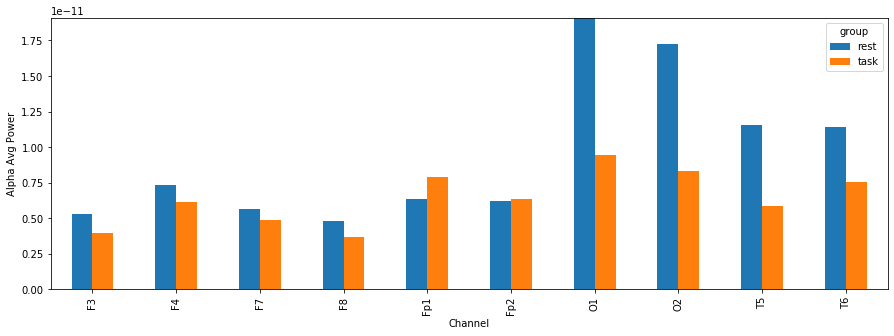

In [105]:
pd.concat([pd.DataFrame(result_rest),\
           pd.DataFrame(result_task)]).pivot("channel", "group", "values").plot(kind='bar')

plt.ylabel("Alpha Avg Power")
plt.xlabel("Channel")
plt.show()

In [59]:
result_task

{'F3': 3.95798828063032e-12,
 'F4': 6.1598445662168795e-12,
 'F7': 4.8862679662987235e-12,
 'F8': 3.7078966428636035e-12,
 'Fp1': 7.93281534689835e-12,
 'Fp2': 6.337546783121725e-12,
 'O1': 9.427970258412318e-12,
 'O2': 8.350391125691259e-12,
 'T5': 5.832275903407142e-12,
 'T6': 7.580184719706723e-12}

In [84]:
for ch in eeg.ch_names:
    print(f"{ch} : Rest-{result_rest[ch]}, Task-{result_task[ch]}, {result_rest[ch] > result_task[ch]}")

Fp1 : Rest-6.362416679912614e-12, Task-7.93281534689835e-12, False
F7 : Rest-5.672703042685491e-12, Task-4.8862679662987235e-12, True
F3 : Rest-5.281610753495065e-12, Task-3.95798828063032e-12, True
T5 : Rest-1.1542641766803603e-11, Task-5.832275903407142e-12, True
O1 : Rest-1.9106116956568255e-11, Task-9.427970258412318e-12, True
Fp2 : Rest-6.246933360940019e-12, Task-6.337546783121725e-12, False
F4 : Rest-7.367998814266453e-12, Task-6.1598445662168795e-12, True
F8 : Rest-4.816649409536537e-12, Task-3.7078966428636035e-12, True
T6 : Rest-1.1405219650541886e-11, Task-7.580184719706723e-12, True
O2 : Rest-1.723269128862285e-11, Task-8.350391125691259e-12, True


In [0]:
# Getting electrode location

_URL = "https://raw.githubusercontent.com/sappelhoff/eeg_positions/master/data/standard_1005_2D.tsv"
data = urlopen(_URL)

_loc = data.read().decode('utf-8')
data.close()
_loc = _loc.splitlines()
_loc = [line.split('\t') for line in _loc]
_loc = {line[0]: [line[1],line[2]] for line in _loc }

In [74]:
_loc['Fp1']

['-0.2245225362872422', '0.6909854851031322']

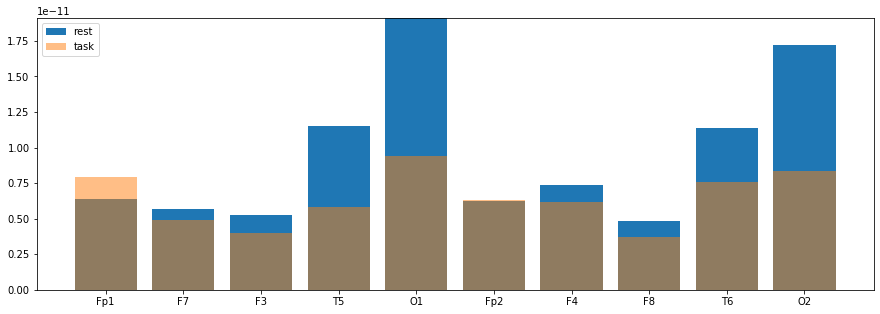

In [96]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.bar(list(result_rest.keys()), list(result_rest.values()), label = 'rest')
plt.bar(list(result_rest.keys()), list(result_task.values()), label = 'task', alpha=.5)
plt.legend()

In [97]:
pd.DataFrame(result_rest)

ValueError: ignored